In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import PolynomialFeatures

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [2]:
# Caricare i dati di training, i dati di test, e verificare il # di osservazioni e il # di caratteristiche per ciascuno dei due
app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
print('Shape di addestramento: ', app_train.shape)
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Shape di addestramento: ', app_test.shape)

Shape di addestramento:  (307511, 122)
Shape di addestramento:  (48744, 121)


In [3]:
# Create a label encoder object
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

def mylabelencoder(df):
    le_count = 0
    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 3:
                df[col] = df[col].fillna("")
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])

                # Keep track of how many columns were label encoded
                le_count += 1            
    print('%d columns were label encoded.' % le_count)

In [4]:
# Controlla che codifichi lo stesso numero di colonne su train e su test
mylabelencoder(app_train)
mylabelencoder(app_test)

5 columns were label encoded.
5 columns were label encoded.


In [5]:
# One Hot Encoding delle altre feature categoriche
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [6]:
# Riallineamento delle colonne
# Cerca le colonne differenti tra i due set, togliendo dal train la target per cercare le differenze
colset_train = set(app_train.columns)
colset_test = set(app_test.columns)
colset_train.discard('TARGET')
colset_train.difference(colset_test)

{'NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave'}

In [7]:
for k in list(colset_train.difference(colset_test)):
    app_test[k] = 0 # Default a 0 perché se le colonne non appaiono in test sono sempre non-hot
    
print(app_train.shape)
print(app_test.shape)
set(app_train.columns).difference(set(app_test.columns))

# Test ha una colonna in meno perché non contiene TARGET

(307511, 240)
(48744, 239)


{'TARGET'}

In [8]:
# Analisi degli outlier
app_train.dtypes.value_counts()

uint8      129
float64     65
int64       46
dtype: int64

In [9]:
(app_train["DAYS_BIRTH"]/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [10]:
(app_train["DAYS_EMPLOYED"]/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

<AxesSubplot:ylabel='Frequency'>

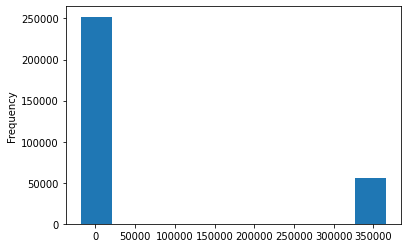

In [11]:
app_train["DAYS_EMPLOYED"].plot(kind="hist")

In [12]:
 app_train["DAYS_EMPLOYED"] == 365243

0         False
1         False
2         False
3         False
4         False
          ...  
307506    False
307507     True
307508    False
307509    False
307510    False
Name: DAYS_EMPLOYED, Length: 307511, dtype: bool

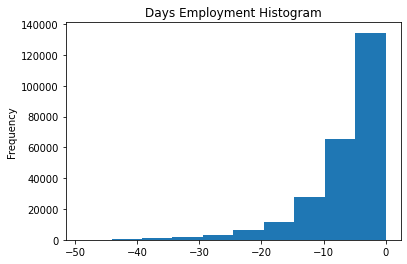

In [13]:
# Identificare e filtrare le osservazioni che hanno la caratt. DAYS EMPLOYED con un valore outlier
# Per caso, l'outlier è legato al fatto che il prestito è andato in default? In che proporzione di occasioni?
anomalies = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED_ANOM'] = anomalies
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
(app_train['DAYS_EMPLOYED']/365).plot.hist(title = 'Days Employment Histogram');


In [14]:
app_train["DAYS_EMPLOYED_ANOM"].value_counts()

False    252137
True      55374
Name: DAYS_EMPLOYED_ANOM, dtype: int64

In [15]:
#import seaborn as sns
#sns.pairplot(app_train.iloc[:,:10])
# Plotting as desired
# app_train.iloc[:,27:70].plot.hist(subplots=True, legend=False)
# Analisi delle collinearità
#correlations = app_train.corr()
#correlations
#correlations["TARGET"].sort_values().head(10)
#correlations["TARGET"].sort_values().tail(10)
#app_train['DAYS_BIRTH'].corr(app_train['TARGET'])
#app_train['DAYS_BIRTH']/-365).corr(app_train['TARGET'])
#app_train['DAYS_BIRTH']/-365).corr(app_train['TARGET'])

In [16]:
##import seaborn as sns
#import matplotlib.pyplot as plt

#plt.style.use('fivethirtyeight')
#plt.figure(figsize = (10, 8))

#sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0' )
#sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1' )

# Metti la legenda
#plt.legend()


In [17]:
# Creare dei kernel plot su EXT_SOURCE(1,2,3) rispetto a TARGET per valutarne la "quantità di segnale"

#sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'EXT_SOURCE_1'], label = 'target == 0' )
#sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'EXT_SOURCE_1'], label = 'target == 1' )

# Metti la legenda
#plt.legend()

In [18]:
# Creare dei kernel plot su EXT_SOURCE(1,2,3) rispetto a TARGET per valutarne la "quantità di segnale"

#sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'EXT_SOURCE_2'], label = 'target == 0' )
#sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'EXT_SOURCE_2'], label = 'target == 1' )

# Metti la legenda
#plt.legend()

In [19]:
# Creare dei kernel plot su EXT_SOURCE(1,2,3) rispetto a TARGET per valutarne la "quantità di segnale"

#sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'EXT_SOURCE_3'], label = 'target == 0' )
#sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'EXT_SOURCE_3'], label = 'target == 1' )

# Metti la legenda
#plt.legend()

In [20]:
# Extract the EXT_SOURCE variables and show correlations
#ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
#ext_data_corrs = ext_data.corr()
#ext_data_corrs

In [21]:
#plt.figure(figsize = (8, 6))

# Heatmap of correlations
#sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
#plt.title('Correlation Heatmap');

In [22]:
# Feature Engineering
# Combinazioni polinomiali delle caratteristiche
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
#poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
#poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
#poly_target = app_train['TARGET']

In [23]:
# Imputazione dei valori mancanti
# https://scikit-learn.org/stable/modules/impute.html
#poly_features['EXT_SOURCE_1'].plot(kind="hist")

In [24]:
#poly_features['EXT_SOURCE_1'].isnull().value_counts()

In [25]:
# Inseriamo NaN al posto di null
#poly_features['EXT_SOURCE_1'] = poly_features['EXT_SOURCE_1'].fillna(np.nan)
#poly_features

In [26]:
# Uso di SimpleImputer per imputazione automatica di valori tramite una funzione nelle celle vuote
#import numpy as np
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(missing_values=np.nan, strategy='median')
#poly_features_imputed = imp.fit_transform(poly_features)
#poly_features_imputed_df = pd.DataFrame(poly_features_imputed, columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

In [27]:
#poly_features_test_imputed = imp.fit_transform(poly_features_test)
#poly_features_test_imputed_df = pd.DataFrame(poly_features_test_imputed, columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

In [28]:
# Tappati tutti i buchi con le mediane
#poly_features_imputed_df.isnull().value_counts()
#poly_features_test_imputed_df.isnull().value_counts()

In [29]:
# Calcola combinazioni polinomiali delle feature del dataframe Df
#from sklearn.preprocessing import PolynomialFeatures
#def poly_transformer(df):
 #   poly_transformer = PolynomialFeatures(degree = 3)
  #  poly_transformer.fit(df)
   # poly_features_df = pd.DataFrame(poly_transformer.transform(df), columns=poly_transformer.get_feature_names(df.columns))
    #poly_features_df = poly_features_df.drop(labels='1', axis=1)
    #return poly_features_df

In [30]:
# Ora finalmente posso usare le polynomial features
#from sklearn.preprocessing import PolynomialFeatures
#poly_transformer = PolynomialFeatures(degree = 3)
#poly_transformer.fit(poly_features_imputed_df)

In [31]:
#poly_transformer.transform(poly_features_imputed_df)

In [32]:
#poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

In [33]:
#poly_features_df = pd.DataFrame(poly_transformer.transform(poly_features_imputed_df), columns=poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

In [34]:
#poly_features_df

In [35]:
#poly_features_df = poly_features_df.drop(labels='1', axis=1)

In [36]:
#poly_features_df['TARGET'] = poly_target

In [37]:
# Vediamo ora se rispetto alle sole features predominanti di base, quelle costruite in polinomiali risultano maggiormente correlate al target
#poly_collinears = poly_features_df.corr()

In [38]:
#poly_collinears['TARGET'].sort_values().head(5)

In [39]:
#poly_collinears['TARGET'].sort_values().tail(5)

In [40]:
#poly_features_test_df = pd.DataFrame(poly_transformer.transform(poly_features_test_imputed_df), columns=poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

In [41]:
#poly_features_test_df = poly_features_test_df.drop(labels='1', axis=1)

In [42]:
#prova_poly_features

In [43]:
# Provo la mia funzione
#prova_poly_features = poly_features_imputed_df.copy() # copia per separare i df nella trasformazione
#pippo = poly_transformer(prova_poly_features)

In [44]:
# Sistemare la poly transformation in una funzione
# Creare delle caratteristiche derivate ("in modo business")


In [45]:
# Creo una copia per valore e non per riferimento dei dati di train e di test
#app_train_domain = app_train.copy()
#app_test_domain = app_test.copy()

In [46]:
# Funzione che calcola nuove caratteristiche di dominio
#def calculate_domain_data(df):    
 #   df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
  #  df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
   # df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    #df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

In [47]:
#calculate_domain_data(app_train_domain)

In [48]:
#app_train_domain

In [49]:
# Infine, provare con la visualizzazione kernel density a dimostrare se qualcuna di queste nuove caratteristiche create (sia polinominali, sia di business)
# ha un particolare potere "separatorio" rispetto al target
#def mykdeplot(df, field):
 #   sns.kdeplot(df.loc[app_train['TARGET'] == 0, field], label = 'target == 0' )
  #  sns.kdeplot(df.loc[app_train['TARGET'] == 1, field], label = 'target == 1' )
    
    # Metti la legenda
   # plt.legend()

In [50]:
#mykdeplot(poly_features_df, 'EXT_SOURCE_2 EXT_SOURCE_3')

In [51]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
app_train_imputed = imp.fit_transform(app_train)
app_train_imputed_df = pd.DataFrame(app_train_imputed, columns=app_train.columns)

In [52]:
app_test_imputed = imp.fit_transform(app_test)
app_test_imputed_df = pd.DataFrame(app_test_imputed, columns=app_test.columns)

In [53]:
# # 2) Anziché fittare il modello su tutto il df "app_train", usare train_test_split per splittare app_train in app_train_train e app_train_test

from sklearn.model_selection import train_test_split
X=app_train_imputed_df.drop(['TARGET','DAYS_EMPLOYED_ANOM'], axis=1)
y=app_train_imputed_df['TARGET'].to_frame() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [54]:
print(X_train.shape)
print(y_test.shape)

(184506, 239)
(123005, 1)


In [55]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C = 0.0001, solver='liblinear') 
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9200195114019756

In [56]:
# uso il modello fittato per fare la previsione
log_reg.predict_proba(app_test_imputed_df)[:,1]

array([0.09107859, 0.09339138, 0.05209273, ..., 0.06792408, 0.05710815,
       0.10176074])

In [57]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg.predict_proba(app_test_imputed_df)[:,1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
submit

,SK_ID_CURR,TARGET
0,100001,0.091079
1,100005,0.093391
2,100013,0.052093
3,100028,0.035028
4,100038,0.082924
...,...,...
48739,456221,0.048501
48740,456222,0.140448
48741,456223,0.067924
48742,456224,0.057108


In [59]:
submit.to_csv('submission.csv', index=False)

In [60]:
#from sklearn import svm
#clf = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [61]:
# 6) RIpetere usando RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
rf.score(X_test, y_test) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.9200195114019756

In [62]:
rf.predict_proba(app_test_imputed_df)[:,1]

array([0.08956192, 0.07873897, 0.07332674, ..., 0.08152986, 0.07584689,
       0.0968416 ])

In [63]:
submitrf = app_test[['SK_ID_CURR']]
submitrf['TARGET'] = rf.predict_proba(app_test_imputed_df)[:,1]
submitrf.to_csv('submission.csv', index=False)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
# Extract feature importances
features=list(app_test_imputed_df.columns)
feature_importance_values = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
feature_importances = feature_importances.sort_values('importance',ascending=False)
feature_importances

,feature,importance
34,EXT_SOURCE_3,0.161543
32,EXT_SOURCE_1,0.127261
33,EXT_SOURCE_2,0.081329
11,DAYS_BIRTH,0.062480
2,CODE_GENDER,0.055910
...,...,...
109,AMT_REQ_CREDIT_BUREAU_YEAR,0.000000
111,NAME_TYPE_SUITE_Family,0.000000
112,NAME_TYPE_SUITE_Group of people,0.000000
113,NAME_TYPE_SUITE_Other_A,0.000000


In [65]:
app_train_top=feature_importances[:10]
app_train_top

,feature,importance
34,EXT_SOURCE_3,0.161543
32,EXT_SOURCE_1,0.127261
33,EXT_SOURCE_2,0.081329
11,DAYS_BIRTH,0.062480
2,CODE_GENDER,0.055910
12,DAYS_EMPLOYED,0.049209
23,REGION_RATING_CLIENT,0.032383
129,NAME_FAMILY_STATUS_Civil marriage,0.031781
30,REG_CITY_NOT_WORK_CITY,0.031246
9,AMT_GOODS_PRICE,0.030436


In [66]:
app_test_top=app_test_imputed_df[['SK_ID_CURR','EXT_SOURCE_3','EXT_SOURCE_2','DAYS_BIRTH','CODE_GENDER','DAYS_EMPLOYED','REGION_RATING_CLIENT']]
app_test_top

,SK_ID_CURR,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,CODE_GENDER,DAYS_EMPLOYED,REGION_RATING_CLIENT
0,100001.0,0.159520,0.789654,-19241.0,0.0,-2329.0,2.0
1,100005.0,0.432962,0.291656,-18064.0,1.0,-4469.0,2.0
2,100013.0,0.610991,0.699787,-20038.0,1.0,-4458.0,2.0
3,100028.0,0.612704,0.509677,-13976.0,0.0,-1866.0,2.0
4,100038.0,0.519097,0.425687,-13040.0,1.0,-2191.0,2.0
...,...,...,...,...,...,...,...
48739,456221.0,0.643026,0.648575,-19970.0,0.0,-5169.0,3.0
48740,456222.0,0.519097,0.684596,-11186.0,0.0,-1149.0,2.0
48741,456223.0,0.283712,0.632770,-15922.0,0.0,-3037.0,2.0
48742,456224.0,0.595456,0.445701,-13968.0,1.0,-2731.0,2.0


In [67]:
#seleziono solo caratteristiche più significative
app_train_top=app_train_imputed_df[['SK_ID_CURR','TARGET','EXT_SOURCE_3','EXT_SOURCE_2','DAYS_BIRTH','CODE_GENDER','DAYS_EMPLOYED','REGION_RATING_CLIENT']]
app_train_top


,SK_ID_CURR,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,CODE_GENDER,DAYS_EMPLOYED,REGION_RATING_CLIENT
0,100002.0,1.0,0.139376,0.262949,-9461.0,1.0,-637.0,2.0
1,100003.0,0.0,0.535276,0.622246,-16765.0,0.0,-1188.0,1.0
2,100004.0,0.0,0.729567,0.555912,-19046.0,1.0,-225.0,2.0
3,100006.0,0.0,0.535276,0.650442,-19005.0,0.0,-3039.0,2.0
4,100007.0,0.0,0.535276,0.322738,-19932.0,1.0,-3038.0,2.0
...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,0.535276,0.681632,-9327.0,1.0,-236.0,1.0
307507,456252.0,0.0,0.535276,0.115992,-20775.0,0.0,-1648.0,2.0
307508,456253.0,0.0,0.218859,0.535722,-14966.0,0.0,-7921.0,3.0
307509,456254.0,1.0,0.661024,0.514163,-11961.0,0.0,-4786.0,2.0


In [68]:
from sklearn.model_selection import train_test_split
X=app_train_top.drop(['TARGET'], axis=1)
y=app_train_top['TARGET'].to_frame()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [69]:
print(X_test.shape)
print(y_test.shape)

(123005, 7)
(123005, 1)


In [70]:
#ripeto la random forest
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(max_depth=4, random_state=0)
rf1.fit(X_train, y_train)
rf1.score(X_test, y_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.9200195114019756

In [71]:
rf1.predict_proba(app_test_top)[:,1]

array([0.12247729, 0.10330695, 0.04314517, ..., 0.09266703, 0.05829711,
       0.11657265])

In [72]:
submitrf1 = app_test[['SK_ID_CURR']]
submitrf1['TARGET'] = rf1.predict_proba(app_test_top)[:,1]
submitrf1['TARGET'] = rf1.predict_proba(app_test_top)[:,1]
submitrf1.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
# Caricare i dati di bureau
#bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
#print('bureau: ', bureau.shape)
#bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')
#print('bureau_balance: ', bureau_balance.shape)

In [74]:
#mylabelencoder(bureau)
#mylabelencoder(bureau_balance)

In [75]:
# One Hot Encoding delle altre feature categoriche
#bureau = pd.get_dummies(bureau)
#bureau_balance = pd.get_dummies(bureau_balance)

In [76]:
# Analisi degli outlier
#bureau.dtypes.value_counts()
#bureau_balance.dtypes.value_counts()

In [77]:
#import numpy as np
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(missing_values=np.nan, strategy='median')
#bureau_imputed = imp.fit_transform(bureau)
#bureau_imputed_df = pd.DataFrame(bureau_imputed, columns=bureau.columns)


In [78]:
#bureau_balance_imputed = imp.fit_transform(bureau_balance)
#bureau_balance_imputed_df = pd.DataFrame(bureau_balance, columns=app_test.columns)

In [79]:
#top_bureau=pd.merge(app_train_top,bureau_imputed_df,on='SK_ID_CURR',how='right')

In [80]:
#app_train_top.info()

In [81]:
#bureau_imputed_df.info()

In [82]:
#from sklearn.model_selection import train_test_split
#X=top_bureau.drop(['TARGET'], axis=1)
#y=top_bureau['TARGET'].to_frame()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [83]:
#print(X_test.shape)
#print(y_test.shape)

In [84]:
#ripeto la random forest
#from sklearn.ensemble import RandomForestClassifier
#rf1 = RandomForestClassifier(max_depth=2, random_state=0)
#rf1.fit(X_train, y_train)
#rf1.score(X_test, y_test)